In [4]:
import pyLDAvis
import pyLDAvis.lda_model
import seaborn as sns
from html import unescape
from google.colab import drive
import os, re, nltk, matplotlib.pyplot as plt, numpy as np, xml.etree.ElementTree as ET
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, LatentDirichletAllocation

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**The xml files are read from a physical address, from each one only the Abstract field is read as it is the only one of interest. Within a function the content of each file is read and the special characters that were found are removed from the abstract. Each abstract is then added into a list.**

In [19]:
#Function to extract abstract from XML file
def extract_abstract_from_xml(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    abstract_element = root.find(".//AbstractNarration")

    if abstract_element is not None:
        abstract_text = abstract_element.text
        abstract_text = unescape(abstract_text)
        abstract_text = re.sub(r'<br\s*/?>', ' ', abstract_text)
        abstract_text = re.sub(r"\\", "", abstract_text)
        abstract_text = abstract_text.replace("’", "").replace("'", "").replace(",", "").replace(".", "")\
          .replace("-", " ").replace("(", "").replace(")", "").replace("/", "").replace(":", "").replace("*", "")\
          .replace("\"", "").replace("“", "").replace("”", "").replace(";", "")
        return abstract_text
    else:
        return None

abstracts = []
ruta_archivos = "/content/gdrive/My Drive/Abstracts/"

# Iterate through XML files in the folder
for filename in os.listdir(ruta_archivos):
    if filename.endswith('.xml'):
        xml_file_path = os.path.join(ruta_archivos, filename)

        # Extract abstract from each XML file
        abstract = extract_abstract_from_xml(xml_file_path)

        # Append abstract to the list if it exists
        if abstract is not None:
            abstracts.append(abstract)

#abstracts

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Exploratory Data Analysis: Calculate the length of each abstract and store them in a list. Print Descriptive Statistics.**

In [21]:
abstract_lengths = [len(abstract.split()) for abstract in abstracts]

print("Descriptive statistics")
print("Average length:", np.mean(abstract_lengths))
print("Minimum length:", np.min(abstract_lengths))
print("Maximum length:", np.max(abstract_lengths))

Descriptive statistics
Average length: 381.88
Minimum length: 213
Maximum length: 592


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Exploratory Data Analysis: Length Distribution Visualization**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


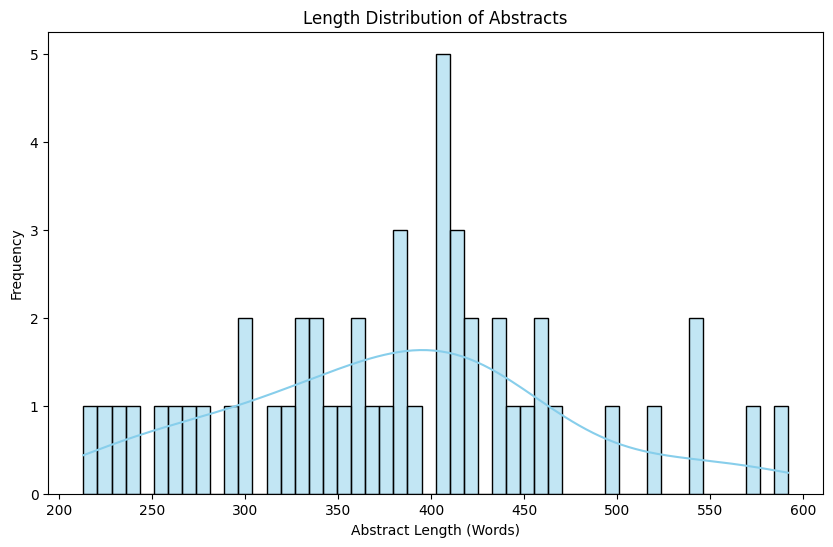

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(abstract_lengths, bins=50, kde=True, color='skyblue')
plt.title('Length Distribution of Abstracts')
plt.xlabel('Abstract Length (Words)')
plt.ylabel('Frequency')
plt.show()

**Downloading packages required for preprocessing**

In [24]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**This code tokenizes text, normalizes it, and removes common stop words to prepare it for further analysis.**

In [25]:
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return tokens

processed_abstracts = [preprocess_text(abstract) for abstract in abstracts]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**As part of the EDA, a cloud of words is printed to display the most relevant ones within the corpus.**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


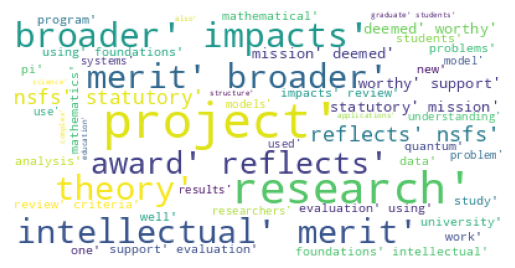

In [28]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=50,
                          max_font_size=40,
                          random_state=100
                         ).generate(str(processed_abstracts))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

**Vectorization using TF-IDF and Topic Modeling using LDA**

In [30]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
tfidf_matrix = vectorizer.fit_transform(processed_abstracts)

num_topics = 10
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42, learning_method='online')
document_topics = lda_model.fit_transform(tfidf_matrix)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


 **Interactive Topic Modeling Visualization with PyLDAvis**

In [31]:
pyLDAvis.enable_notebook()
pyLDAvis.lda_model.prepare(lda_model, tfidf_matrix, vectorizer, mds='tsne')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
5       25.816946   35.523994       1        1  29.489254
0      -13.585363  -21.177801       2        1  17.326098
8      -83.754234  -26.545877       3        1  15.091263
2       22.808294  105.405678       4        1  12.211626
4      126.348450  -26.869719       5        1   6.601283
9       55.240879  -26.989914       6        1   6.533181
1      -17.376350  -93.669991       7        1   4.520137
7       64.374031  -98.059303       8        1   4.376992
3      -50.122414   53.052639       9        1   2.932615
6       98.528404   51.715904      10        1   0.917550, topic_info=              Term      Freq     Total Category  logprob  loglift
2909  transmission  0.000000  0.000000  Default  30.0000  30.0000
2442    resilience  0.000000  0.000000  Default  29.0000  29.0000
1150         films  0.000000  0.000000  Default  28.0000  28.0000
96        algebras  0.000000  0.000000  Default  27.0000  27.0000
2629          soil  0.000000  0.000000  Default  26.0000  26.0000
...            ...       ...       ...      ...      ...      ...
2909  transmission  0.001754  0.172436  Topic10  -7.8577   0.1031
2657      specific  0.001749  0.171576  Topic10  -7.8603   0.1055
1665        levels  0.001719  0.160358  Topic10  -7.8779   0.1555
3078          well  0.001730  0.194059  Topic10  -7.8716  -0.0289
1266          goal  0.001721  0.186293  Topic10  -7.8766   0.0069

[441 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 9, 3, 5, 10, 2, 8, 4, 7])

**Using Gensim for LDA and Extracting Topics. This classifies abstracts into a topic**

In [32]:
dictionary = Dictionary(processed_abstracts)
corpus = [dictionary.doc2bow(abstract) for abstract in processed_abstracts]
tfidf_model = TfidfModel(corpus)
tfidf_corpus = tfidf_model[corpus]

lda_gensim = LdaModel(tfidf_corpus, id2word=dictionary, num_topics=num_topics, passes=10)
topics = lda_gensim.print_topics(num_words=5)  # Adjust the number of words based on your preference
for topic in topics:
    print(topic)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.002*"conference" + 0.002*"categories" + 0.001*"mathematical" + 0.001*"oram" + 0.001*"transport"')
(1, '0.002*"lopfo" + 0.002*"apoptosis" + 0.002*"algebras" + 0.002*"operator" + 0.002*"index"')
(2, '0.001*"uptake" + 0.001*"fe" + 0.001*"antibiotic" + 0.001*"plants" + 0.001*"von"')
(3, '0.002*"carbon" + 0.002*"pyrogenic" + 0.002*"fire" + 0.002*"amazon" + 0.002*"liquids"')
(4, '0.002*"complex" + 0.002*"soil" + 0.002*"uav" + 0.001*"operator" + 0.001*"neutron"')
(5, '0.003*"iot" + 0.002*"spectra" + 0.001*"operators" + 0.001*"nanoparticles" + 0.001*"delivery"')
(6, '0.003*"transmission" + 0.003*"resilience" + 0.002*"fractal" + 0.001*"infrastructure" + 0.001*"data"')
(7, '0.002*"gbm" + 0.002*"rationality" + 0.002*"organoids" + 0.002*"epithelial" + 0.001*"vcp"')
(8, '0.002*"dynamical" + 0.002*"quantum" + 0.002*"memories" + 0.002*"false" + 0.001*"peek"')
(9, '0.002*"stem" + 0.002*"faculty" + 0.002*"exclusion" + 0.002*"epistemic" + 0.001*"image"')


**Previous steps to group abstracts based on their semantic similarity.**

In [33]:
num_clusters = 5
topic_distributions = [x[0] for x in lda_gensim.get_document_topics(tfidf_corpus)]

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(topic_distributions)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


**Using cluster labels to group abstracts based on their similarity**

In [35]:
clustered_abstracts = {}
for i, label in enumerate(cluster_labels):
    if label not in clustered_abstracts:
        clustered_abstracts[label] = []
    clustered_abstracts[label].append(processed_abstracts[i])

print("Cluster 1 abstracts:", clustered_abstracts[0])
print("Cluster 2 abstracts:", clustered_abstracts[1])
print("Cluster 3 abstracts:", clustered_abstracts[2])
print("Cluster 4 abstracts:", clustered_abstracts[3])
print("Cluster 5 abstracts:", clustered_abstracts[4])

Cluster 1 abstracts: [['fire', 'plays', 'key', 'role', 'earths', 'ecosystem', 'dynamics', 'profound', 'effects', 'biogeochemical', 'processes', 'climate', 'environmental', 'quality', 'beyond', 'significant', 'threat', 'people', 'infrastructures', 'year', 'seen', 'forest', 'fires', 'amazon', 'basin', 'brazil', 'since', 'providing', 'compelling', 'opportunity', 'study', 'impact', 'fires', 'carbon', 'fluxes', 'amazon', 'river', 'system', 'together', 'auspiciously', 'timed', 'cruise', 'planned', 'guyanas', 'mudbanks', 'characterize', 'corresponding', 'signature', 'biomass', 'burning', 'along', 'entire', 'continuum', 'source', 'land', 'sink', 'oceans', 'project', 'takes', 'advantage', 'opportunity', 'time', 'series', 'sampling', 'dissolved', 'particulate', 'load', 'headwaters', 'lower', 'reaches', 'amazon', 'river', 'effort', 'combined', 'targeted', 'sampling', 'campaigns', 'across', 'full', 'river', 'depth', 'profile', 'high', 'low', 'discharge', 'capture', 'export', 'material', 'atlantic'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Apply PCA to reduce dimensionality to 2 dimensions and visualize clusters**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


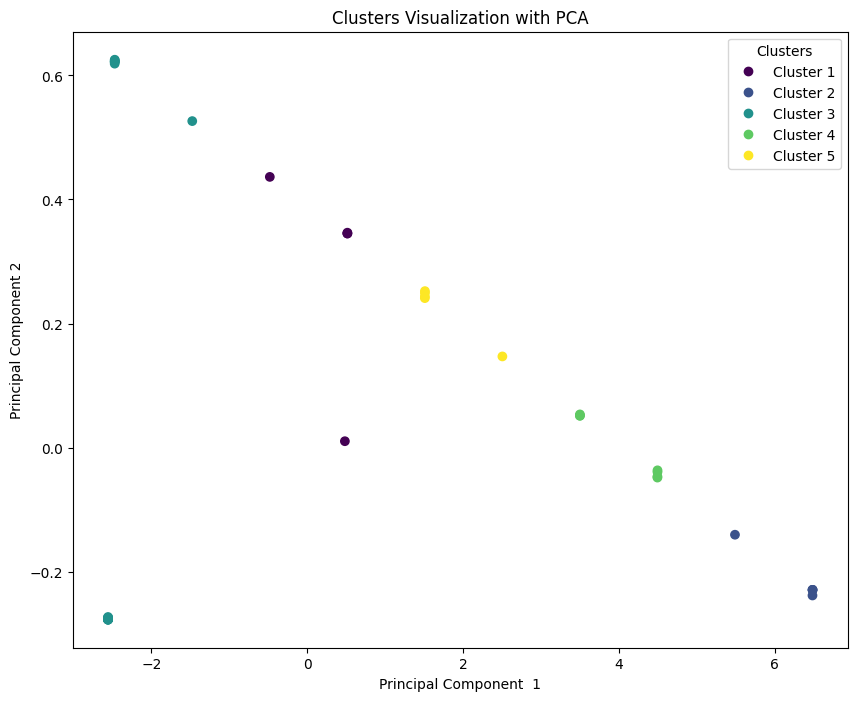

In [36]:
pca = PCA(n_components=2)
abstracts_2d = pca.fit_transform(topic_distributions)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(abstracts_2d[:, 0], abstracts_2d[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Clusters Visualization with PCA')
plt.xlabel('Principal Component  1')
plt.ylabel('Principal Component 2')

legend_labels = [f'Cluster {i+1}' for i in range(num_clusters)]
plt.legend(handles=scatter.legend_elements()[0], title='Clusters', labels=legend_labels)
plt.show()